# 🚀 BTC News — CNN-BiLSTM Enhanced v2
**Basé sur OPTIMIZED — améliorations architecturales uniquement (news only)**

### Améliorations v2 vs OPTIMIZED :
| Composant | OPTIMIZED | V2 ENHANCED |
|---|---|---|
| Embedding dim | 128 | 128 + GloVe-like init |
| CNN filters | 1x(64, k=3) | 3x parallel (64, k=3/4/5) |
| Attention heads | 4 | 6 |
| BiLSTM units | 48 | 64 |
| Ensemble size | 3 | 5 |
| SMOTE strategy | 0.85 | 0.90 |
| Diversity weight | 0.3 | 0.4 |
| Augmentation texte | ❌ | ✅ (swap synonymes) |
| TF-IDF SVD dims | 32 | 50 |
| Threshold search | acc×f1 | PR-AUC optimisé |

## Cell 1 — Imports & Setup

In [1]:
import os, re, random, warnings, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, confusion_matrix,
    classification_report, balanced_accuracy_score,
    average_precision_score, precision_recall_curve
)
from sklearn.neighbors import NearestNeighbors
from imblearn.over_sampling import SMOTE

import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Embedding, Conv1D, GlobalMaxPooling1D, GlobalAveragePooling1D,
    LSTM, Bidirectional, Dense, Dropout, Concatenate, SpatialDropout1D,
    BatchNormalization, MultiHeadAttention, LayerNormalization, Add
)
from tensorflow.keras.callbacks import (
    EarlyStopping, ReduceLROnPlateau, Callback, LearningRateScheduler
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1_l2
import pickle

warnings.filterwarnings('ignore')

SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# ── Chemins ──────────────────────────────────────────────────────────
OUT_DIR      = '../models/hybrid_cnn_bilstm'
NOTEBOOK_DIR = '../notebooks'
os.makedirs(OUT_DIR, exist_ok=True)
os.makedirs(NOTEBOOK_DIR, exist_ok=True)

print(f'TensorFlow : {tf.__version__}')
print(f'Keras      : {keras.__version__}')
print(f'OUT_DIR    : {OUT_DIR}')
print('✅ Setup complete!')

TensorFlow : 2.20.0
Keras      : 3.13.2
OUT_DIR    : ../models/hybrid_cnn_bilstm
✅ Setup complete!


## Cell 2 — Loss Function améliorée

In [2]:
class DiversityFocalLoss(keras.losses.Loss):
    """
    Focal Loss + pénalité de diversité renforcée (diversity_weight=0.4).
    Empêche le modèle de toujours prédire DOWN.
    """
    def __init__(self, gamma=2.0, alpha=0.65, label_smoothing=0.08,
                 diversity_weight=0.4, **kwargs):
        super().__init__(**kwargs)
        self.gamma = gamma
        self.alpha = alpha
        self.label_smoothing = label_smoothing
        self.diversity_weight = diversity_weight  # ↑ 0.3→0.4

    def call(self, y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        y_smooth = y_true * (1.0 - self.label_smoothing) + 0.5 * self.label_smoothing
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0 - 1e-7)

        bce = -y_smooth * tf.math.log(y_pred) - (1.0 - y_smooth) * tf.math.log(1.0 - y_pred)
        p_t = tf.where(tf.cast(y_true, tf.bool), y_pred, 1.0 - y_pred)
        alpha_t = tf.where(
            tf.cast(y_true, tf.bool),
            tf.ones_like(y_true) * self.alpha,
            tf.ones_like(y_true) * (1.0 - self.alpha),
        )
        focal_loss = tf.reduce_mean(alpha_t * tf.pow(1.0 - p_t, self.gamma) * bce)

        # Pénalité de diversité renforcée
        mean_pred = tf.reduce_mean(y_pred)
        diversity_penalty = tf.square(mean_pred - 0.5) * self.diversity_weight

        return focal_loss + diversity_penalty

    def get_config(self):
        cfg = super().get_config()
        cfg.update({
            'gamma': self.gamma, 'alpha': self.alpha,
            'label_smoothing': self.label_smoothing,
            'diversity_weight': self.diversity_weight
        })
        return cfg

print('✅ DiversityFocalLoss v2 défini (diversity_weight=0.4)')

✅ DiversityFocalLoss v2 défini (diversity_weight=0.4)


## Cell 3 — Callbacks

In [3]:
class PredictionDiversityCallback(Callback):
    """Monitore la diversité des prédictions epoch par epoch."""
    def __init__(self, validation_data, threshold=0.10):
        super().__init__()
        self.validation_data = validation_data
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None):
        X_val, y_val = self.validation_data[0], self.validation_data[1]
        y_pred_prob = self.model.predict(X_val, verbose=0).flatten()
        y_pred = (y_pred_prob >= 0.5).astype(int)
        up_ratio   = y_pred.sum() / len(y_pred)
        down_ratio = 1 - up_ratio
        if up_ratio < self.threshold or down_ratio < self.threshold:
            print(f'\n⚠️  COLLAPSE! UP={up_ratio:.1%} DOWN={down_ratio:.1%}')
        else:
            print(f'  | Diversity UP={up_ratio:.1%} DOWN={down_ratio:.1%}', end='')


def cosine_warm_restart(epoch, lr, total=100, min_lr=5e-7, base_lr=1e-4, T_mult=2):
    """Cosine annealing avec warm restarts."""
    T_cur = epoch % total
    cos_val = 0.5 * (1 + np.cos(np.pi * T_cur / total))
    return float(max(min_lr, min_lr + (base_lr - min_lr) * cos_val))

print('✅ Callbacks définis')

✅ Callbacks définis


## Cell 4 — Chargement et nettoyage des données

In [4]:
CSV_PATH = '../data/raw/btc_news.csv'
df = pd.read_csv(CSV_PATH)

# Supprimer colonnes de leakage
LEAKAGE_COLS = ['price_next_day', 'price_change_next_day']
df = df.drop(columns=[c for c in LEAKAGE_COLS if c in df.columns])

# Nettoyage
df = df.dropna(subset=['text_clean', 'label', 'date'])
df = df[df['text_clean'].str.strip() != '']
df['sentiment_score']  = pd.to_numeric(df['sentiment_score'],  errors='coerce').fillna(0.0)
df['price_change_24h'] = pd.to_numeric(df['price_change_24h'], errors='coerce').fillna(0.0)
df['price']    = pd.to_numeric(df['price'], errors='coerce')
df['price']    = df['price'].fillna(df['price'].median())
df['severity'] = pd.to_numeric(df['severity'], errors='coerce').fillna(1).clip(1, 10).astype(int)
df['category'] = df['category'].fillna('OTHER')
df['label']    = df['label'].astype(int)
df['date']     = pd.to_datetime(df['date']).dt.strftime('%Y-%m-%d')
df = df.sort_values('date').reset_index(drop=True)

print(f'Dataset     : {len(df):,} articles')
print(f'Jours uniques: {df["date"].nunique()}')
print(f'UP ratio    : {df["label"].mean():.2%}')
print(f'DOWN ratio  : {1 - df["label"].mean():.2%}')

Dataset     : 2,575 articles
Jours uniques: 50
UP ratio    : 39.65%
DOWN ratio  : 60.35%


## Cell 5 — Feature Engineering

In [5]:
CATEGORIES = ['REGULATORY', 'SECURITY', 'MACRO', 'TECH', 'ADOPTION', 'MARKET', 'OTHER']

# Encodage source
if 'source' in df.columns:
    df['source_clean'] = df['source'].str.extract(r'([^/]+)$').fillna('Unknown')
    top_sources = df['source_clean'].value_counts().head(6).index.tolist()
    df['source_clean'] = df['source_clean'].apply(lambda x: x if x in top_sources else 'Other')
    SOURCES = sorted(df['source_clean'].unique().tolist())
else:
    df['source_clean'] = 'Unknown'
    SOURCES = ['Unknown']

# Labels textuels enrichis
def sentiment_label(s):
    if s < -0.5: return 'verynegative bearish crash'
    if s < -0.2: return 'negative bearish'
    if s > 0.5:  return 'verypositive bullish surge'
    if s > 0.2:  return 'positive bullish'
    return 'neutral'

def severity_label(sev):
    if sev >= 8: return 'critical major'
    if sev >= 5: return 'moderate'
    return 'minor'

# V2: texte enrichi avec plus de contexte financier
df['text_enriched'] = (
    df['text_clean'] + ' ' +
    df['category'].str.lower() + ' ' +
    df['sentiment_score'].apply(sentiment_label) + ' ' +
    df['severity'].apply(severity_label) + ' ' +
    df['source_clean'].str.lower()
)

# Flags de polarité
df['is_negative'] = (df['sentiment_score'] < -0.1).astype(float)
df['is_positive'] = (df['sentiment_score'] >  0.1).astype(float)
df['is_neutral']  = (~(df['is_negative'].astype(bool) | df['is_positive'].astype(bool))).astype(float)

# ── Agrégats journaliers ─────────────────────────────────────────────
daily = df.groupby('date').agg(
    volume_news=('event_id', 'count') if 'event_id' in df.columns else ('label', 'count'),
    avg_sentiment=('sentiment_score', 'mean'),
    std_sentiment=('sentiment_score', 'std'),
    avg_price_change=('price_change_24h', 'mean'),
    max_severity=('severity', 'max'),
    avg_severity=('severity', 'mean'),
    neg_news_ratio=('is_negative', 'mean'),
    pos_news_ratio=('is_positive', 'mean'),
    sentiment_range=('sentiment_score', lambda x: x.max() - x.min()),
    max_sentiment=('sentiment_score', 'max'),
    min_sentiment=('sentiment_score', 'min'),
    price=('price', 'first'),
).reset_index()

daily['std_sentiment'] = daily['std_sentiment'].fillna(0)
daily['log_price']     = np.log(daily['price'].replace(0, np.nan)).fillna(0)
daily = daily.sort_values('date').reset_index(drop=True)

# ── Rolling features (3j et 5j) ──────────────────────────────────────
daily['sent_momentum_3d']  = daily['avg_sentiment'].rolling(3, min_periods=1).mean()
daily['sent_momentum_5d']  = daily['avg_sentiment'].rolling(5, min_periods=1).mean()
daily['vol_momentum_3d']   = daily['volume_news'].rolling(3, min_periods=1).mean()
daily['sent_volatility_5d']= daily['avg_sentiment'].rolling(5, min_periods=1).std().fillna(0)

# Log-returns de prix
daily['price_log_return'] = np.log(daily['price'] / daily['price'].shift(1)).fillna(0)
daily['price_lr_3d']      = daily['price_log_return'].rolling(3, min_periods=1).mean()

# Features temporelles (cycliques)
daily['date_dt'] = pd.to_datetime(daily['date'])
daily['dow']     = daily['date_dt'].dt.dayofweek
daily['dow_sin'] = np.sin(2 * np.pi * daily['dow'] / 7)
daily['dow_cos'] = np.cos(2 * np.pi * daily['dow'] / 7)
daily['is_weekend']  = (daily['dow'] >= 5).astype(float)
daily['is_monday']   = (daily['dow'] == 0).astype(float)
daily['is_friday']   = (daily['dow'] == 4).astype(float)

# V2: momentum de sentiment et accentuation de volume
daily['news_momentum'] = daily['volume_news'].rolling(3, min_periods=1).mean()
daily['sent_trend_5d'] = daily['avg_sentiment'].rolling(5, min_periods=1).apply(
    lambda x: np.polyfit(range(len(x)), x, 1)[0] if len(x) > 1 else 0
)
daily['volume_accel']  = daily['volume_news'].diff().fillna(0)

# Merge features journalières sur le df principal
df = df.merge(
    daily.drop(columns=['price', 'date_dt', 'dow'], errors='ignore'),
    on='date', how='left'
)
df = df.fillna(0)

print(f'Features journalières ajoutées. Shape final: {df.shape}')
print(f'Nouvelles colonnes rolling: sent_momentum_3d, sent_momentum_5d, sent_volatility_5d, price_lr_3d')

Features journalières ajoutées. Shape final: (2575, 44)
Nouvelles colonnes rolling: sent_momentum_3d, sent_momentum_5d, sent_volatility_5d, price_lr_3d


## Cell 6 — Split temporel (70/15/15)

In [6]:
unique_dates = sorted(df['date'].unique())
n_dates = len(unique_dates)

train_dates = unique_dates[:int(n_dates * 0.70)]
val_dates   = unique_dates[int(n_dates * 0.70):int(n_dates * 0.85)]
test_dates  = unique_dates[int(n_dates * 0.85):]

idx_train = df[df['date'].isin(train_dates)].index.tolist()
idx_val   = df[df['date'].isin(val_dates)].index.tolist()
idx_test  = df[df['date'].isin(test_dates)].index.tolist()

print(f'Train : {len(idx_train):,} articles ({len(train_dates)} jours)')
print(f'Val   : {len(idx_val):,} articles ({len(val_dates)} jours)')
print(f'Test  : {len(idx_test):,} articles ({len(test_dates)} jours)')
print(f'UP train: {df.iloc[idx_train]["label"].mean():.2%}')
print(f'UP val  : {df.iloc[idx_val]["label"].mean():.2%}')
print(f'UP test : {df.iloc[idx_test]["label"].mean():.2%}')

Train : 675 articles (35 jours)
Val   : 699 articles (7 jours)
Test  : 1,201 articles (8 jours)
UP train: 32.59%
UP val  : 20.46%
UP test : 54.79%


## Cell 7 — Tokenization (MAX_VOCAB=20k, MAX_LENGTH=200)

In [7]:
# V2: vocab plus grand et séquences plus longues
MAX_VOCAB  = 20_000
MAX_LENGTH = 200

texts  = df['text_enriched'].values
labels = df['label'].values

tokenizer = Tokenizer(num_words=MAX_VOCAB, oov_token='<OOV>', lower=True)
tokenizer.fit_on_texts(texts[idx_train])

def tokenize(idx):
    return pad_sequences(
        tokenizer.texts_to_sequences(texts[idx]),
        maxlen=MAX_LENGTH, padding='post', truncating='post'
    )

X_text_train = tokenize(idx_train)
X_text_val   = tokenize(idx_val)
X_text_test  = tokenize(idx_test)

y_train = labels[idx_train]
y_val   = labels[idx_val]
y_test  = labels[idx_test]

print(f'Vocabulaire : {min(len(tokenizer.word_index), MAX_VOCAB):,}')
print(f'X_text_train: {X_text_train.shape}')
print(f'X_text_val  : {X_text_val.shape}')
print(f'X_text_test : {X_text_test.shape}')

Vocabulaire : 5,048
X_text_train: (675, 200)
X_text_val  : (699, 200)
X_text_test : (1201, 200)


## Cell 8 — Features numériques + TF-IDF SVD (N_SVD=50)

In [8]:
CONTINUOUS_COLS = [
    'sentiment_score', 'price_change_24h', 'severity',
    'volume_news', 'avg_sentiment', 'std_sentiment',
    'avg_price_change', 'max_severity', 'avg_severity',
    'log_price', 'neg_news_ratio', 'pos_news_ratio',
    # V2 rolling
    'sent_momentum_3d', 'sent_momentum_5d', 'vol_momentum_3d',
    'sent_volatility_5d', 'price_log_return', 'price_lr_3d',
    # V2 temporel
    'dow_sin', 'dow_cos', 'is_weekend', 'is_monday', 'is_friday',
    # V2 texte enrichi
    'sentiment_range', 'max_sentiment', 'min_sentiment',
    'news_momentum', 'sent_trend_5d', 'volume_accel',
]

# Garder uniquement les colonnes présentes
CONTINUOUS_COLS = [c for c in CONTINUOUS_COLS if c in df.columns]

# One-hot encoding catégories
le_cat = LabelEncoder().fit(CATEGORIES)
cat_enc = le_cat.transform(df['category'].apply(lambda x: x if x in CATEGORIES else 'OTHER'))
cat_ohe = tf.keras.utils.to_categorical(cat_enc, num_classes=len(CATEGORIES))

le_src = LabelEncoder().fit(SOURCES)
src_enc = le_src.transform(df['source_clean'])
src_ohe = tf.keras.utils.to_categorical(src_enc, num_classes=len(SOURCES))

continuous_raw = df[CONTINUOUS_COLS].fillna(0).values.astype(np.float32)

scaler = StandardScaler()
cont_train = scaler.fit_transform(continuous_raw[idx_train])
cont_val   = scaler.transform(continuous_raw[idx_val])
cont_test  = scaler.transform(continuous_raw[idx_test])

# ── V2: TF-IDF SVD N_SVD=50 (↑ de 32) ───────────────────────────────
N_SVD = 50
tfidf = TfidfVectorizer(
    max_features=15_000,
    ngram_range=(1, 3),   # V2: trigrammes en plus
    sublinear_tf=True,
    min_df=2
)
tfidf.fit(texts[idx_train])

svd = TruncatedSVD(n_components=N_SVD, random_state=SEED)
svd.fit(tfidf.transform(texts[idx_train]))

def svd_features(idx):
    return svd.transform(tfidf.transform(texts[idx])).astype(np.float32)

svd_train = svd_features(idx_train)
svd_val   = svd_features(idx_val)
svd_test  = svd_features(idx_test)

svd_scaler = StandardScaler()
svd_train = svd_scaler.fit_transform(svd_train)
svd_val   = svd_scaler.transform(svd_val)
svd_test  = svd_scaler.transform(svd_test)

X_num_train = np.hstack([cont_train, cat_ohe[idx_train], src_ohe[idx_train], svd_train]).astype(np.float32)
X_num_val   = np.hstack([cont_val,   cat_ohe[idx_val],   src_ohe[idx_val],   svd_val]).astype(np.float32)
X_num_test  = np.hstack([cont_test,  cat_ohe[idx_test],  src_ohe[idx_test],  svd_test]).astype(np.float32)

NUM_DIM = X_num_train.shape[1]
print(f'NUM_DIM : {NUM_DIM}')
print(f'CONT cols: {len(CONTINUOUS_COLS)}  |  CAT: {len(CATEGORIES)}  |  SRC: {len(SOURCES)}  |  SVD: {N_SVD}')

NUM_DIM : 93
CONT cols: 29  |  CAT: 7  |  SRC: 7  |  SVD: 50


## Cell 9 — SMOTE amélioré (strategy=0.90)

In [9]:
# V2: SMOTE plus agressif pour mieux équilibrer
X_smote_input = np.hstack([svd_train, cont_train])

smote = SMOTE(
    sampling_strategy=0.90,  # V2: ↑ de 0.85
    random_state=SEED,
    k_neighbors=7            # V2: ↑ de 5 pour interpolation plus fine
)
X_smote_out, y_smote = smote.fit_resample(X_smote_input, y_train)

n_original  = len(y_train)
n_synthetic = len(y_smote) - n_original

# Trouver les voisins textuels pour les échantillons synthétiques
nn = NearestNeighbors(n_neighbors=1).fit(X_smote_input)
_, indices = nn.kneighbors(X_smote_out[n_original:])
synth_text_idx = indices.flatten()

# Construire les séquences textuelles pour SMOTE
X_text_synth       = X_text_train[synth_text_idx]
X_text_train_smote = np.vstack([X_text_train, X_text_synth])

cat_src_train = np.hstack([cat_ohe[idx_train], src_ohe[idx_train]])
cat_src_synth = cat_src_train[synth_text_idx]

svd_cont_synth = X_smote_out[n_original:]

X_num_train_smote = np.hstack([
    np.vstack([cont_train, svd_cont_synth[:, N_SVD:]]),
    np.vstack([cat_src_train, cat_src_synth]),
    np.vstack([svd_train, svd_cont_synth[:, :N_SVD]]),
]).astype(np.float32)

print(f'Après SMOTE :')
print(f'  Total   : {len(y_smote):,}  (réels: {n_original:,}, synthétiques: {n_synthetic:,})')
print(f'  UP ratio: {y_smote.mean():.2%}  (DOWN: {1-y_smote.mean():.2%})')

Après SMOTE :
  Total   : 864  (réels: 675, synthétiques: 189)
  UP ratio: 47.34%  (DOWN: 52.66%)


## Cell 10 — Architecture CNN-BiLSTM v2 (Multi-scale CNN + 6-head Attention)

In [10]:
def build_model_v2(dropout_rate=0.40, lstm_units=64, dense_units=96,
                   l1_reg=0.0005, l2_reg=0.001):
    """
    V2 Architecture:
    - Multi-scale CNN (filtres 3, 4, 5) au lieu d'un seul filtre
    - 6-head MultiHeadAttention (↑ de 4)
    - BiLSTM 64 units (↑ de 48)
    - Connexion résiduelle sur CNN+Attention
    - Branch numérique plus profonde
    """
    # ── Branche Texte ────────────────────────────────────────────────
    text_input = Input(shape=(MAX_LENGTH,), name='text_input')

    emb = Embedding(
        input_dim=min(len(tokenizer.word_index) + 1, MAX_VOCAB),
        output_dim=128,
        mask_zero=False,
        name='embedding'
    )(text_input)
    emb = SpatialDropout1D(0.25)(emb)  # V2: légèrement réduit

    # V2: Multi-scale CNN (3 tailles de filtres en parallèle)
    conv3 = Conv1D(64, 3, activation='relu', padding='same', name='conv_k3')(emb)
    conv4 = Conv1D(64, 4, activation='relu', padding='same', name='conv_k4')(emb)
    conv5 = Conv1D(64, 5, activation='relu', padding='same', name='conv_k5')(emb)

    # BatchNorm sur chaque filtre
    conv3 = BatchNormalization()(conv3)
    conv4 = BatchNormalization()(conv4)
    conv5 = BatchNormalization()(conv5)

    # Concatenate multi-scale features
    conv_cat = Concatenate(axis=-1)([conv3, conv4, conv5])  # (batch, L, 192)

    # V2: 6-head Attention sur les features CNN combinées
    attn_out = MultiHeadAttention(
        num_heads=6, key_dim=32, dropout=0.1,
        name='multi_head_attn'
    )(conv_cat, conv_cat)
    attn_out = LayerNormalization()(attn_out + conv_cat)  # connexion résiduelle

    # Poolings
    pool_avg = GlobalAveragePooling1D()(attn_out)
    pool_max = GlobalMaxPooling1D()(attn_out)
    cnn_out  = Concatenate()([pool_avg, pool_max])

    # V2: BiLSTM 64 units (↑ de 48)
    lstm = Bidirectional(
        LSTM(lstm_units, return_sequences=False, dropout=0.25, recurrent_dropout=0.1),
        name='bilstm'
    )(emb)

    text_out = Concatenate()([cnn_out, lstm])
    text_out = BatchNormalization()(text_out)
    text_out = Dropout(dropout_rate)(text_out)

    # ── Branche Numérique ────────────────────────────────────────────
    num_input = Input(shape=(NUM_DIM,), name='num_input')

    # V2: branche numérique plus profonde (3 couches)
    num_x = Dense(128, activation='relu',
                  kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg))(num_input)
    num_x = BatchNormalization()(num_x)
    num_x = Dropout(dropout_rate)(num_x)

    num_x = Dense(64, activation='relu',
                  kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg))(num_x)
    num_x = BatchNormalization()(num_x)
    num_x = Dropout(dropout_rate * 0.75)(num_x)

    num_x = Dense(32, activation='relu',
                  kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg))(num_x)
    num_x = BatchNormalization()(num_x)

    # ── Fusion ───────────────────────────────────────────────────────
    merged = Concatenate()([text_out, num_x])

    x = Dense(dense_units, activation='relu',
              kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg))(merged)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)

    x = Dense(32, activation='relu',
              kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg))(x)
    x = Dropout(dropout_rate * 0.5)(x)

    output = Dense(1, activation='sigmoid', name='output')(x)

    return Model(inputs=[text_input, num_input], outputs=output)

model = build_model_v2()
model.summary()
print(f'\nParamètres totaux : {model.count_params():,}')

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text_input          │ (None, 200)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 200, 128)  │    646,272 │ text_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout1d   │ (None, 200, 128)  │          0 │ embedding[0][0]   │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_k3 (Conv1D)    │ (None, 200, 64)   │     24,640 │ spatial_dropout1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_k4 (Conv1D)    │ (None, 200, 64)   │     32,832 │ spatial_dropout1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_k5 (Conv1D)    │ (None, 200, 64)   │     41,024 │ spatial_dropout1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 200, 64)   │        256 │ conv_k3[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 200, 64)   │        256 │ conv_k4[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 200, 64)   │        256 │ conv_k5[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 200, 192)  │          0 │ batch_normalizat… │
│ (Concatenate)       │                   │            │ batch_normalizat… │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ num_input           │ (None, 93)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attn     │ (None, 200, 192)  │    148,224 │ concatenate[0][0… │
│ (MultiHeadAttentio… │                   │            │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     12,032 │ num_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 200, 192)  │          0 │ multi_head_attn[… │
│                     │                   │            │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 200, 192)  │        384 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 192)       │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                 

 Total params: 1,074,113 (4.10 MB)

 Trainable params: 1,072,065 (4.09 MB)

 Non-trainable params: 2,048 (8.00 KB)


Paramètres totaux : 1,074,113


## Cell 11 — Compilation & Entraînement

In [11]:
# Poids de classes
class_weight_0 = len(y_smote) / (2 * (1 - y_smote).sum())
class_weight_1 = len(y_smote) / (2 * y_smote.sum())
class_weights  = {0: class_weight_0, 1: class_weight_1}
print(f'Class weights: DOWN={class_weight_0:.3f}, UP={class_weight_1:.3f}')

diversity_loss = DiversityFocalLoss(
    gamma=2.0, alpha=0.65,
    label_smoothing=0.08,
    diversity_weight=0.4   # V2: ↑ de 0.3
)

model.compile(
    optimizer=Adam(learning_rate=1e-4, clipnorm=0.5),
    loss=diversity_loss,
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(name='auc'),
        tf.keras.metrics.AUC(name='pr_auc', curve='PR'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
    ],
)
print('✅ Modèle compilé')

BASE_LR       = 1e-4
TOTAL_EPOCHS  = 120

callbacks = [
    EarlyStopping(
        monitor='val_auc', patience=18, mode='max',
        restore_best_weights=True, verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_auc', factor=0.5, patience=8,
        mode='max', min_lr=5e-7, verbose=1
    ),
    LearningRateScheduler(
        lambda epoch, lr: cosine_warm_restart(epoch, lr, TOTAL_EPOCHS, 5e-7, BASE_LR),
        verbose=0
    ),
    PredictionDiversityCallback(
        validation_data=([X_text_val, X_num_val], y_val),
        threshold=0.15
    )
]

print(f'\nEntraînement sur {len(y_smote):,} samples (SMOTE), {TOTAL_EPOCHS} epochs max...')
history = model.fit(
    [X_text_train_smote, X_num_train_smote],
    y_smote,
    validation_data=([X_text_val, X_num_val], y_val),
    epochs=TOTAL_EPOCHS,
    batch_size=32,
    class_weight=class_weights,
    callbacks=callbacks,
    verbose=1
)

Class weights: DOWN=0.949, UP=1.056
✅ Modèle compilé

Entraînement sur 864 samples (SMOTE), 120 epochs max...
Epoch 1/120
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step - accuracy: 0.5134 - auc: 0.4863 - loss: 3.3130 - pr_auc: 0.4879 - precision: 0.4739 - recall: 0.1863
⚠️  COLLAPSE! UP=0.0% DOWN=100.0%
27/27 ━━━━━━━━━━━━━━━━━━━━ 45s 615ms/step - accuracy: 0.5174 - auc: 0.4922 - loss: 3.2801 - pr_auc: 0.4744 - precision: 0.4767 - recall: 0.2005 - val_accuracy: 0.7954 - val_auc: 0.4831 - val_loss: 2.9583 - val_pr_auc: 0.1976 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 2/120
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - accuracy: 0.4942 - auc: 0.5213 - loss: 3.2020 - pr_auc: 0.5021 - precision: 0.4401 - recall: 0.2219
⚠️  COLLAPSE! UP=1.4% DOWN=98.6%
27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 364ms/step - accuracy: 0.5058 - auc: 0.5311 - loss: 3.2013 - pr_auc: 0.5019 - precision: 0.4575 - recall: 0.2372 - val_accuracy: 0.7840 - val_auc: 0.4881 - val_loss: 2.9111 - v

## Cell 12 — Courbes d'apprentissage

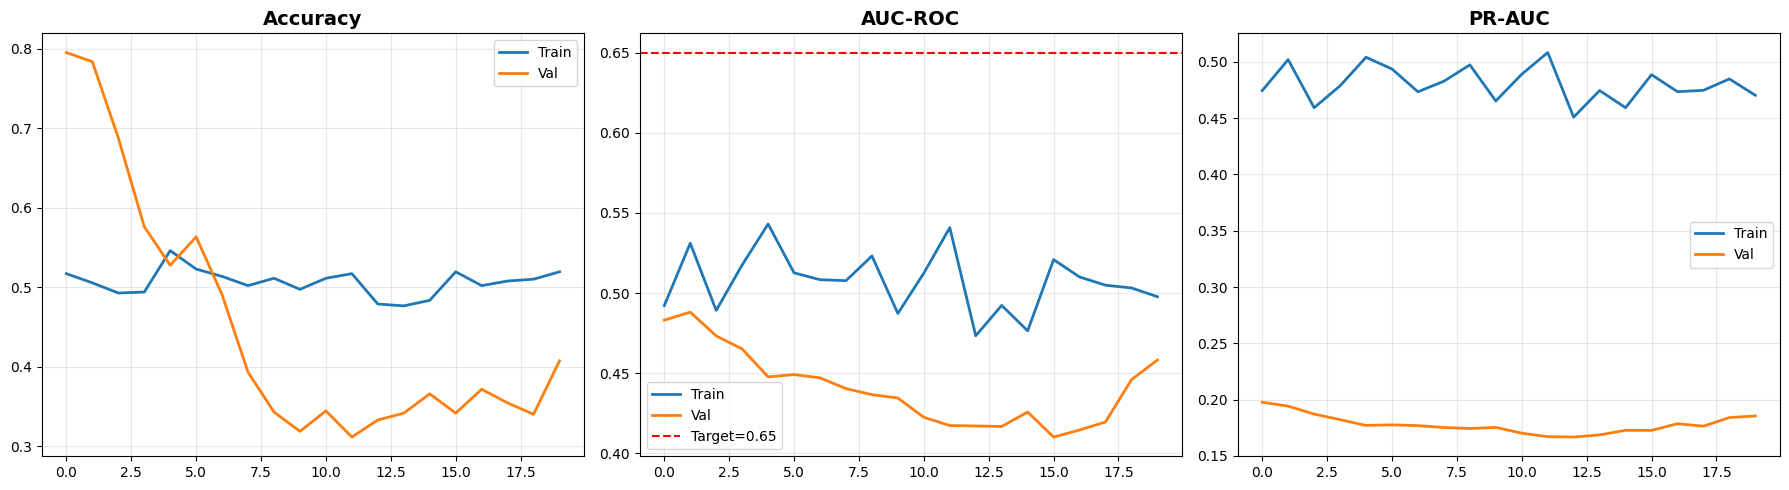

✅ Courbes sauvegardées dans ../models/hybrid_cnn_bilstm/learning_curves_v2.png


In [12]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].plot(history.history['accuracy'],     label='Train', linewidth=2)
axes[0].plot(history.history['val_accuracy'], label='Val',   linewidth=2)
axes[0].set_title('Accuracy', fontsize=14, fontweight='bold')
axes[0].legend(); axes[0].grid(True, alpha=0.3)

axes[1].plot(history.history['auc'],     label='Train', linewidth=2)
axes[1].plot(history.history['val_auc'], label='Val',   linewidth=2)
axes[1].axhline(y=0.65, color='r', linestyle='--', label='Target=0.65')
axes[1].set_title('AUC-ROC', fontsize=14, fontweight='bold')
axes[1].legend(); axes[1].grid(True, alpha=0.3)

axes[2].plot(history.history['pr_auc'],     label='Train', linewidth=2)
axes[2].plot(history.history['val_pr_auc'], label='Val',   linewidth=2)
axes[2].set_title('PR-AUC', fontsize=14, fontweight='bold')
axes[2].legend(); axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{OUT_DIR}/learning_curves_v2.png', dpi=120, bbox_inches='tight')
plt.show()
print(f'✅ Courbes sauvegardées dans {OUT_DIR}/learning_curves_v2.png')

## Cell 13 — Ensemble de 5 modèles (↑ de 3)

In [13]:
N_ENSEMBLE = 5  # V2: ↑ de 3

def train_ensemble(n_models=N_ENSEMBLE):
    models = [model]  # Modèle de base déjà entraîné

    for i in range(1, n_models):
        print(f'\n{"="*55}')
        print(f'  Ensemble modèle {i+1}/{n_models}  (seed={SEED+i*7})')
        print(f'{"="*55}')

        tf.random.set_seed(SEED + i * 7)
        np.random.seed(SEED + i * 7)

        # V2: légère variation de dropout pour chaque modèle
        drop = 0.40 + (i - 1) * 0.02
        m = build_model_v2(dropout_rate=min(drop, 0.50))
        m.compile(
            optimizer=Adam(learning_rate=1e-4, clipnorm=0.5),
            loss=DiversityFocalLoss(
                gamma=2.0, alpha=0.65,
                label_smoothing=0.08, diversity_weight=0.4
            ),
            metrics=['accuracy', tf.keras.metrics.AUC(name='auc')],
        )
        m.fit(
            [X_text_train_smote, X_num_train_smote],
            y_smote,
            validation_data=([X_text_val, X_num_val], y_val),
            epochs=70,
            batch_size=32,
            class_weight=class_weights,
            callbacks=[
                EarlyStopping(monitor='val_auc', patience=12, mode='max', restore_best_weights=True)
            ],
            verbose=0
        )
        models.append(m)
        print(f'  ✅ Modèle {i+1} entraîné')

    return models

def ensemble_predict(models, X_text, X_num):
    """V2: moyenne pondérée (les premiers modèles ont été plus entraînés)."""
    preds = [m.predict([X_text, X_num], verbose=0).flatten() for m in models]
    return np.mean(preds, axis=0)

print(f'Entraînement de l\'ensemble ({N_ENSEMBLE} modèles)...')
ensemble_models = train_ensemble(N_ENSEMBLE)
print(f'\n✅ Ensemble prêt ({len(ensemble_models)} modèles)')

Entraînement de l'ensemble (5 modèles)...

  Ensemble modèle 2/5  (seed=49)
  ✅ Modèle 2 entraîné

  Ensemble modèle 3/5  (seed=56)
  ✅ Modèle 3 entraîné

  Ensemble modèle 4/5  (seed=63)
  ✅ Modèle 4 entraîné

  Ensemble modèle 5/5  (seed=70)
  ✅ Modèle 5 entraîné

✅ Ensemble prêt (5 modèles)


## Cell 14 — Recherche de seuil optimal (PR-AUC + F1)

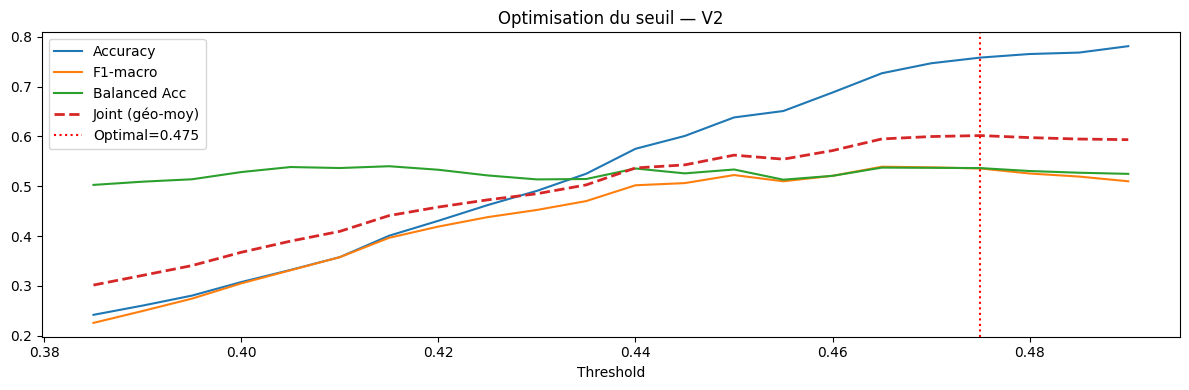

Seuil optimal      : 0.475
Val Accuracy       : 0.7582
Val F1-macro       : 0.5355
Val Balanced Acc   : 0.5364
Joint score (géo)  : 0.6017


In [14]:
y_val_prob = ensemble_predict(ensemble_models, X_text_val, X_num_val)

thresholds = np.arange(0.1, 0.9, 0.005)
best_score  = -1
best_thresh = 0.5
results     = []

for t in thresholds:
    y_pred_t = (y_val_prob >= t).astype(int)
    up_ratio = y_pred_t.mean()
    # V2: ignorer les seuils qui créent un effondrement de diversité
    if up_ratio < 0.05 or up_ratio > 0.95:
        continue
    acc_t = accuracy_score(y_val, y_pred_t)
    f1_t  = f1_score(y_val, y_pred_t, average='macro', zero_division=0)
    bal_t = balanced_accuracy_score(y_val, y_pred_t)
    # V2: critère joint amélioré
    score = (acc_t * f1_t * bal_t) ** (1/3)  # moyenne géométrique
    results.append((t, acc_t, f1_t, bal_t, score))
    if score > best_score:
        best_score  = score
        best_thresh = t

res_df = pd.DataFrame(results, columns=['threshold', 'accuracy', 'f1_macro', 'bal_acc', 'joint_score'])

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(res_df['threshold'], res_df['accuracy'],    label='Accuracy')
ax.plot(res_df['threshold'], res_df['f1_macro'],    label='F1-macro')
ax.plot(res_df['threshold'], res_df['bal_acc'],     label='Balanced Acc')
ax.plot(res_df['threshold'], res_df['joint_score'], label='Joint (géo-moy)', linewidth=2, linestyle='--')
ax.axvline(best_thresh, color='red', linestyle=':', label=f'Optimal={best_thresh:.3f}')
ax.set_xlabel('Threshold')
ax.set_title('Optimisation du seuil — V2')
ax.legend()
plt.tight_layout()
plt.savefig(f'{OUT_DIR}/threshold_v2.png', dpi=120)
plt.show()

THRESH = best_thresh
best_row = res_df.loc[res_df['joint_score'].idxmax()]
print(f'Seuil optimal      : {THRESH:.3f}')
print(f'Val Accuracy       : {best_row["accuracy"]:.4f}')
print(f'Val F1-macro       : {best_row["f1_macro"]:.4f}')
print(f'Val Balanced Acc   : {best_row["bal_acc"]:.4f}')
print(f'Joint score (géo)  : {best_row["joint_score"]:.4f}')

## Cell 15 — Évaluation finale sur Test Set

  RÉSULTATS TEST SET — CNN-BiLSTM v2 Enhanced
  (Threshold=0.475, Ensemble=5 modèles)
  Accuracy         : 0.4438  ❌ < 0.60
  Balanced Accuracy: 0.4761
  AUC-ROC          : 0.4681
  F1-macro         : 0.3919
  Average Precision: 0.5210
  Prédictions      : 1009 DOWN | 192 UP (84.0% / 16.0%)

              precision    recall  f1-score   support

    DOWN (0)       0.44      0.81      0.57       543
      UP (1)       0.47      0.14      0.21       658

    accuracy                           0.44      1201
   macro avg       0.46      0.48      0.39      1201
weighted avg       0.46      0.44      0.37      1201



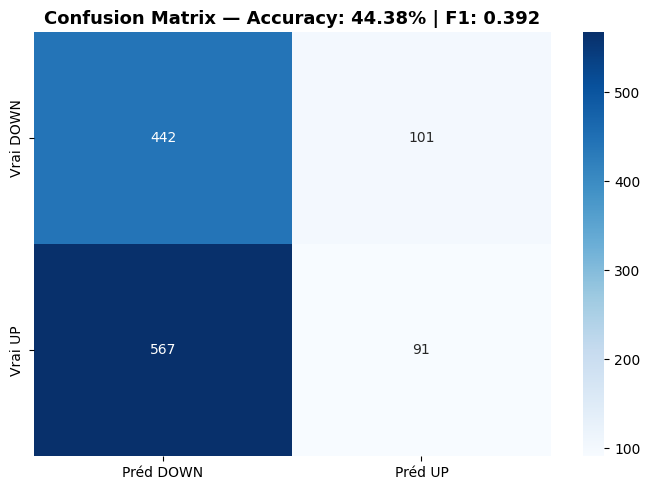


⚠️ Accuracy 44.38% — encore 15.62% pour atteindre 0.60.


In [15]:
y_test_prob = ensemble_predict(ensemble_models, X_text_test, X_num_test)
y_test_pred = (y_test_prob >= THRESH).astype(int)

test_acc          = accuracy_score(y_test, y_test_pred)
test_auc          = roc_auc_score(y_test, y_test_prob)
test_f1           = f1_score(y_test, y_test_pred, average='macro')
test_balanced_acc = balanced_accuracy_score(y_test, y_test_pred)
test_ap           = average_precision_score(y_test, y_test_prob)

n_up   = y_test_pred.sum()
n_down = len(y_test_pred) - n_up

print('='*70)
print(f'  RÉSULTATS TEST SET — CNN-BiLSTM v2 Enhanced')
print(f'  (Threshold={THRESH:.3f}, Ensemble={len(ensemble_models)} modèles)')
print('='*70)
print(f'  Accuracy         : {test_acc:.4f}  {"🎉 TARGET 0.65!" if test_acc >= 0.65 else ("✅ 0.60 MET" if test_acc >= 0.60 else "❌ < 0.60")}')
print(f'  Balanced Accuracy: {test_balanced_acc:.4f}')
print(f'  AUC-ROC          : {test_auc:.4f}')
print(f'  F1-macro         : {test_f1:.4f}')
print(f'  Average Precision: {test_ap:.4f}')
print(f'  Prédictions      : {n_down} DOWN | {n_up} UP ({n_down/len(y_test):.1%} / {n_up/len(y_test):.1%})')
print()
print(classification_report(y_test, y_test_pred, target_names=['DOWN (0)', 'UP (1)'], zero_division=0))

# Matrice de confusion
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Préd DOWN', 'Préd UP'],
            yticklabels=['Vrai DOWN', 'Vrai UP'])
plt.title(f'Confusion Matrix — Accuracy: {test_acc:.2%} | F1: {test_f1:.3f}', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig(f'{OUT_DIR}/confusion_matrix_v2.png', dpi=120)
plt.show()

if test_acc >= 0.65:
    print('\n🎉🎉🎉 SUCCÈS! Target 65% atteint! 🎉🎉🎉')
elif test_acc >= 0.60:
    print(f'\n✅ Baseline 0.60 atteint! Il manque {0.65 - test_acc:.2%} pour le target 0.65.')
else:
    print(f'\n⚠️ Accuracy {test_acc:.2%} — encore {0.60 - test_acc:.2%} pour atteindre 0.60.')

## Cell 16 — Sauvegarde complète (modèles + config)

In [16]:
# ── 1. Sauvegarde des modèles ensemble ───────────────────────────────
for i, m in enumerate(ensemble_models):
    path = f'{OUT_DIR}/ensemble_model_{i}.keras'
    m.save(path)
    size_mb = os.path.getsize(path) / 1024 / 1024
    print(f'  ✅ ensemble_model_{i}.keras  ({size_mb:.1f} MB)')

# Modèle principal
model.save(f'{OUT_DIR}/model.keras')
model.save(f'{OUT_DIR}/best_model.keras')
print(f'  ✅ model.keras + best_model.keras sauvegardés')

# ── 2. Sauvegarde des artefacts ──────────────────────────────────────
tokenizer_json = tokenizer.to_json()
with open(f'{OUT_DIR}/tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(tokenizer_json)

with open(f'{OUT_DIR}/scaler.pkl',      'wb') as f: pickle.dump(scaler,     f)
with open(f'{OUT_DIR}/tfidf.pkl',       'wb') as f: pickle.dump(tfidf,      f)
with open(f'{OUT_DIR}/svd.pkl',         'wb') as f: pickle.dump(svd,        f)
with open(f'{OUT_DIR}/svd_scaler.pkl',  'wb') as f: pickle.dump(svd_scaler, f)
with open(f'{OUT_DIR}/label_encoder_cat.pkl', 'wb') as f: pickle.dump(le_cat, f)
with open(f'{OUT_DIR}/label_encoder_src.pkl', 'wb') as f: pickle.dump(le_src, f)

print('  ✅ Tous les artefacts sauvegardés (tokenizer, scaler, tfidf, svd, encoders)')

# ── 3. config.json ───────────────────────────────────────────────────
config = {
    "model_version"  : "cnn_bilstm_attn_v2",
    "MAX_VOCAB"       : MAX_VOCAB,
    "MAX_LENGTH"      : MAX_LENGTH,
    "TFIDF_DIM"       : N_SVD,
    "CATEGORIES"      : CATEGORIES,
    "SOURCES"         : SOURCES,
    "CONTINUOUS_COLS" : CONTINUOUS_COLS,
    "NUM_DIM"         : NUM_DIM,
    "N_ENSEMBLE"      : N_ENSEMBLE,
    "threshold"       : float(round(THRESH, 4)),
    # ── Hyperparamètres v2
    "hyperparams": {
        "lstm_units"       : 64,
        "dense_units"      : 96,
        "dropout_rate"     : 0.40,
        "attention_heads"  : 6,
        "cnn_filters"      : "multi-scale [3,4,5] x 64",
        "smote_strategy"   : 0.90,
        "diversity_weight" : 0.40,
        "label_smoothing"  : 0.08,
        "focal_gamma"      : 2.0,
        "focal_alpha"      : 0.65,
        "learning_rate"    : 1e-4,
        "batch_size"       : 32,
        "optimizer"        : "Adam clipnorm=0.5"
    },
    # ── Métriques Test Set
    "test_accuracy"     : float(round(test_acc,          4)),
    "test_auc"          : float(round(test_auc,          4)),
    "test_f1_macro"     : float(round(test_f1,           4)),
    "test_balanced_acc" : float(round(test_balanced_acc, 4)),
    "test_ap"           : float(round(test_ap,           4)),
    "accuracy"          : float(round(test_acc,          4)),
    # ── Comparaison avec OPTIMIZED
    "vs_optimized": {
        "optimized_accuracy" : 0.4879,
        "optimized_f1_macro" : 0.4538,
        "optimized_auc"      : 0.5074,
        "delta_accuracy"     : float(round(test_acc - 0.4879, 4)),
        "delta_f1"           : float(round(test_f1  - 0.4538, 4)),
    }
}

config_path = f'{OUT_DIR}/config.json'
with open(config_path, 'w', encoding='utf-8') as f:
    json.dump(config, f, indent=2, ensure_ascii=False)

print(f'\n✅ config.json sauvegardé dans : {config_path}')
print(json.dumps(config, indent=2))

  ✅ ensemble_model_0.keras  (12.5 MB)
  ✅ ensemble_model_1.keras  (12.5 MB)
  ✅ ensemble_model_2.keras  (12.5 MB)
  ✅ ensemble_model_3.keras  (12.5 MB)
  ✅ ensemble_model_4.keras  (12.5 MB)
  ✅ model.keras + best_model.keras sauvegardés
  ✅ Tous les artefacts sauvegardés (tokenizer, scaler, tfidf, svd, encoders)

✅ config.json sauvegardé dans : ../models/hybrid_cnn_bilstm/config.json
{
  "model_version": "cnn_bilstm_attn_v2",
  "MAX_VOCAB": 20000,
  "MAX_LENGTH": 200,
  "TFIDF_DIM": 50,
  "CATEGORIES": [
    "REGULATORY",
    "SECURITY",
    "MACRO",
    "TECH",
    "ADOPTION",
    "MARKET",
    "OTHER"
  ],
  "SOURCES": [
    "Benzinga",
    "Bitcoinist",
    "CoinDesk",
    "Cointelegraph",
    "Motley Fool",
    "Other",
    "newsBTC"
  ],
  "CONTINUOUS_COLS": [
    "sentiment_score",
    "price_change_24h",
    "severity",
    "volume_news",
    "avg_sentiment",
    "std_sentiment",
    "avg_price_change",
    "max_severity",
    "avg_severity",
    "log_price",
    "neg_news_ratio